In [ ]:
# Setup

import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# supress warnings
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Dataset
df = pd.read_csv('/content/drive/MyDrive/Bangkit/Dataset/AllProductPriceDataset.csv', header=0, index_col=0, parse_dates=True)
series_harga = df['Bayam']
df

,Bayam,Kangkung,Sawi,Brokoli,Kubis,Wortel,Kentang,Kacang Polong,Kacang Tanah,Buncis,...,Garu Piring,Lada,Cengkeh,Kayu Manis,Kapulaga,Kunyit,Ubi Jalar,Ubi Kayu,Singkong,Talas
Tanggal,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1500,1000,5500,9000,3500,8000,6000,30000,26000,17000,...,5000,89000,130000,17000,83000,3500,3000,4000,1000,14000
2013-08-01,1500,1000,5500,9000,3500,8000,6000,30000,26000,17000,...,5000,89000,130000,17000,83000,3500,3000,4000,1000,14000
2013-01-15,1500,1000,5500,9000,3500,8000,6000,30000,26000,16000,...,5000,89000,130000,17000,83000,3500,3000,4000,1000,14000
2013-01-22,1500,1000,5500,9000,3500,8000,6000,30000,26000,16000,...,5000,89000,130000,17000,83000,3500,3000,4000,1000,14000
2013-01-29,1500,1000,5500,9000,3500,8000,6000,30000,26000,16000,...,5000,89000,130000,17000,83000,3500,3000,4000,1000,14000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-27,14000,13500,7500,35500,14000,16000,15000,58500,30000,33500,...,9000,149000,199000,22500,87000,9000,9500,6000,2000,24500
2023-03-11,14000,13500,7500,35500,14000,16000,15000,58500,30000,33500,...,9000,149000,199000,22500,87000,9000,9500,6000,2000,24500
2023-10-11,14000,13500,7500,35500,14000,16000,15000,58500,30000,33500,...,9000,149000,199000,22500,87000,9000,9500,6000,2000,24500


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 570 entries, 2013-01-01 to 2023-11-24
Data columns (total 53 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Bayam                 570 non-null    int64
 1   Kangkung              570 non-null    int64
 2   Sawi                  570 non-null    int64
 3   Brokoli               570 non-null    int64
 4   Kubis                 570 non-null    int64
 5   Wortel                570 non-null    int64
 6   Kentang               570 non-null    int64
 7   Kacang Polong         570 non-null    int64
 8   Kacang Tanah          570 non-null    int64
 9   Buncis                570 non-null    int64
 10  Labu Siam             570 non-null    int64
 11  Labu Kuning           570 non-null    int64
 12  Lobak Merah           570 non-null    int64
 13  Lobak Putih           570 non-null    int64
 14  Tomat                 570 non-null    int64
 15  Terong                570 non-null    

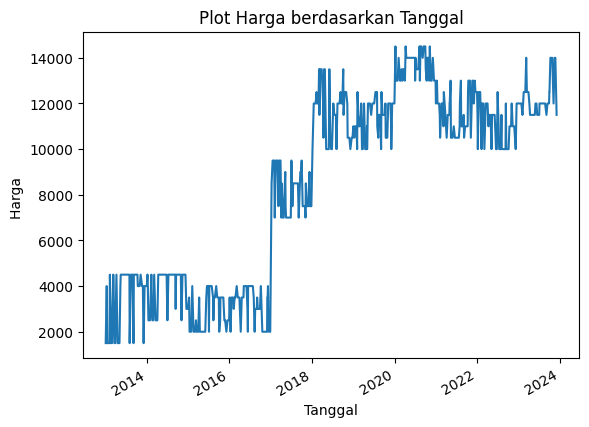

In [ ]:
plt.title('Plot Harga berdasarkan Tanggal')
plt.xlabel('Tanggal')
plt.ylabel('Harga ')
series_harga.plot();

In [ ]:
# Fungsi untuk Membentuk Data untuk Model
def df_to_X_y(df, window_size=75):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_rmse=0.001):
        super(MyCallback, self).__init__()
        self.target_rmse = target_rmse

    def on_epoch_end(self, epoch, logs=None):
        val_rmse = logs.get('val_root_mean_squared_error')
        if val_rmse is not None and val_rmse < self.target_rmse:
            print(f"\nReached target val RMSE ({self.target_rmse}), stopping training.")
            self.model.stop_training = True

In [ ]:
# Normalisasi Data
mean_value = series_harga.mean()
std_value = series_harga.std()
normalized_series = (series_harga - mean_value) / std_value
#deret waktu rata rata 0 standar deviasi 1
#nilai seragam dan lebih kecil

In [ ]:
WINDOW_SIZE = 5
X, y = df_to_X_y(normalized_series, WINDOW_SIZE)
X.shape, y.shape

((565, 5, 1), (565,))

In [ ]:
# Pembagian Data menjadi Train, Validation, dan Test sets
X_train, y_train = X[:510], y[:510]
X_val, y_val = X[510:540], y[510:540]
X_test, y_test = X[540:], y[540:]

# Inisialisasi scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalisasi X_train
X_train = scaler.fit_transform(X_train.reshape(-1, WINDOW_SIZE))

# Normalisasi X_val
X_val = scaler.transform(X_val.reshape(-1, WINDOW_SIZE))

# Normalisasi X_test
X_test = scaler.transform(X_test.reshape(-1, WINDOW_SIZE))

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((510, 5), (510,), (30, 5), (30,), (25, 5), (25,))

In [ ]:
# Arsitektur Model LSTM
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.LSTM(64, return_sequences='True'),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 29585 (115.57 KB)
Trainable params: 29585 (115.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Kompilasi dan Pelatihan Model dengan Normalisasi
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

callbacks = MyCallback(target_rmse=0.001)
model.fit(X_train,
          y_train,
          validation_data=(X_val, y_val),
          epochs=1000,
          callbacks=[callbacks])

Epoch 1/1000
16/16 [==============================] - 10s 155ms/step - loss: 0.9927 - root_mean_squared_error: 0.9963 - val_loss: 0.6855 - val_root_mean_squared_error: 0.8279
Epoch 2/1000
16/16 [==============================] - 0s 16ms/step - loss: 0.9824 - root_mean_squared_error: 0.9912 - val_loss: 0.6783 - val_root_mean_squared_error: 0.8236
Epoch 3/1000
16/16 [==============================] - 0s 17ms/step - loss: 0.9697 - root_mean_squared_error: 0.9848 - val_loss: 0.6705 - val_root_mean_squared_error: 0.8188
Epoch 4/1000
16/16 [==============================] - 0s 23ms/step - loss: 0.9563 - root_mean_squared_error: 0.9779 - val_loss: 0.6617 - val_root_mean_squared_error: 0.8135
Epoch 5/1000
16/16 [==============================] - 0s 18ms/step - loss: 0.9413 - root_mean_squared_error: 0.9702 - val_loss: 0.6520 - val_root_mean_squared_error: 0.8074
Epoch 6/1000
16/16 [==============================] - 0s 24ms/step - loss: 0.9244 - root_mean_squared_error: 0.9614 - val_loss: 0.638

## Visualisasi Data Train

16/16 [==============================] - 0s 3ms/step


<Axes: title={'center': 'Predictions vs Actuals'}>

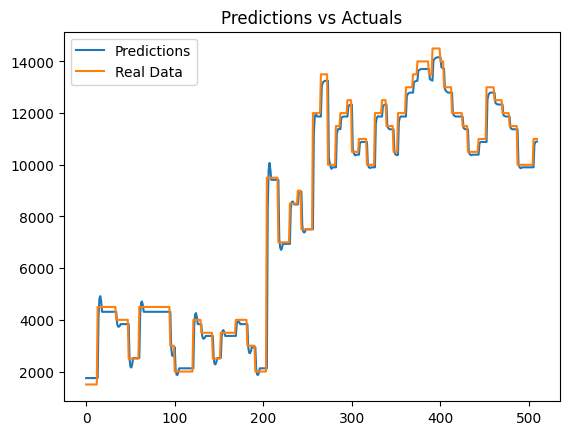

In [ ]:
# Visualisasi Hasil Pelatihan pada Data Training
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Predictions': train_predictions * std_value + mean_value, 'Real Data': y_train * std_value + mean_value})
train_results.plot(title='Predictions vs Actuals')

In [ ]:
train_results

,Predictions,Real Data
0,1748.121094,1500.0
1,1748.121094,1500.0
2,1748.121094,1500.0
3,1748.121094,1500.0
4,1748.121094,1500.0
...,...,...
505,9902.212891,11000.0
506,10766.535156,11000.0
507,10872.045898,11000.0
508,10899.513672,11000.0


1/1 [==============================] - 0s 31ms/step


<Axes: title={'center': 'Validation Set Predictions vs Actuals'}>

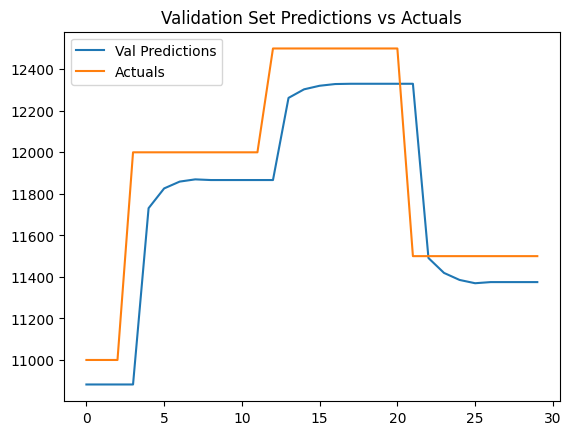

In [ ]:
# Visualisasi Hasil Pelatihan pada Data Validasi
val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions * std_value + mean_value, 'Actuals': y_val * std_value + mean_value})
val_results.plot(title='Validation Set Predictions vs Actuals')

In [ ]:
val_results

,Val Predictions,Actuals
0,10881.998047,11000.0
1,10881.998047,11000.0
2,10881.998047,11000.0
3,10881.998047,12000.0
4,11730.924805,12000.0
5,11826.103516,12000.0
6,11858.981445,12000.0
7,11869.703125,12000.0
8,11866.468750,12000.0
9,11866.468750,12000.0


1/1 [==============================] - 0s 21ms/step


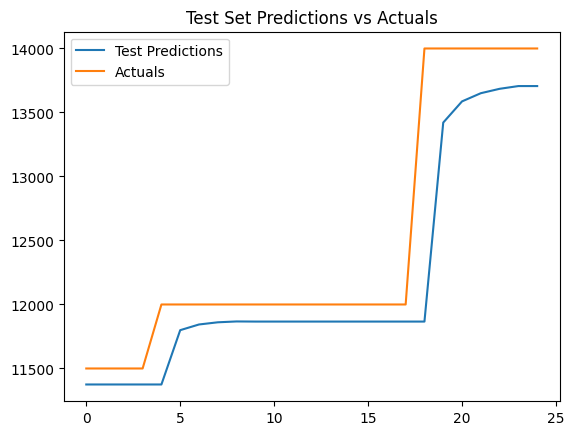

In [ ]:
# Visualisasi Hasil Prediksi pada Data Test
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions * std_value + mean_value, 'Actuals': y_test * std_value + mean_value})
test_results.plot(title='Test Set Predictions vs Actuals')
plt.show()

In [ ]:
test_results

,Test Predictions,Actuals
0,44135.937500,44000.0
1,44130.062500,44000.0
2,44120.703125,44000.0
3,44106.343750,44000.0
4,44097.726562,44500.0
5,44546.078125,44500.0
6,44552.378906,44500.0
7,44561.382812,44500.0
8,44575.625000,44500.0
9,44584.507812,44500.0


In [ ]:
### Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

1/1 [==============================] - 0s 24ms/step


((510, 1), (25, 1))

 # Model Evaluation

In [ ]:
# Evaluation metrices RMSE and MAE
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Train data MSE: ", mean_squared_error(y_train,train_predict))
print("Train data MAE: ", mean_absolute_error(y_train,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))
print("Test data MSE: ", mean_squared_error(y_test,test_predict))
print("Test data MAE: ", mean_absolute_error(y_test,test_predict))

Train data RMSE:  0.1373063444908956
Train data MSE:  0.018853032237452497
Train data MAE:  0.06395793461422898
-------------------------------------------------------------------------------------
Test data RMSE:  0.11828772414854544
Test data MSE:  0.013991985684242378
Test data MAE:  0.06985778853686317


- # Predicting next 7 days

In [ ]:
# Save your model in the SavedModel format
model.save("model_Kemangi.h5")

In [ ]:
# # Fungsi untuk memprediksi harga bayam 1 minggu ke depan
# def predict_future_prices(model, initial_sequence, steps=7):
#     future_prices = []

#     # Gunakan model untuk memprediksi harga bayam setiap hari
#     current_sequence = initial_sequence
#     for i in range(steps):
#         # Lakukan prediksi untuk hari berikutnya
#         next_price = model.predict(np.reshape(current_sequence, (1, WINDOW_SIZE, 1)))
#         future_prices.append(next_price[0, 0])

#         # Perbarui urutan dengan harga yang diprediksi
#         current_sequence = np.append(current_sequence[1:], next_price[0])

#     return future_prices

# # Inisialisasi urutan awal untuk prediksi
# initial_sequence = X_test[-WINDOW_SIZE:].flatten()

# # Lakukan prediksi harga bayam 1 minggu ke depan
# predicted_future_prices = predict_future_prices(model, initial_sequence, steps=7)

# # Invers transform untuk mendapatkan nilai sebenarnya
# predicted_future_prices_actual = scaler.inverse_transform(np.reshape(predicted_future_prices, (len(predicted_future_prices), 1)))

# # Plot harga bayam sebelumnya yang di train, test, dan val
# plt.figure(figsize=(12, 6))
# plt.plot(train_results['Actuals'], label='Train Bayam', color='blue')
# plt.plot(val_results['Actuals'], label='Val Bayam', color='green')
# plt.plot(test_results['Actuals'], label='Test Bayam', color='orange')

# # Plot prediksi harga bayam 1 minggu ke depan
# future_days = np.arange(1, 8)
# plt.plot(future_days, predicted_future_prices_actual, label='Predicted Future Prices', color='red', linestyle='--')

# plt.title('Harga Bayam - Train, Val, Test, dan Prediksi 1 Minggu ke Depan')
# plt.xlabel('Hari')
# plt.ylabel('Harga Bayam')
# plt.legend()
# plt.show()

ValueError: ignored

In [ ]:
# import matplotlib.pyplot as plt

# # Fungsi untuk memprediksi harga di hari selanjutnya
# def predict_next_day(model, last_window):
#     # Lakukan prediksi untuk 1 hari ke depan
#     next_day_pred = model.predict(np.array([last_window]))
#     return next_day_pred[0, 0]

# # Mengambil window terakhir dari data latih untuk digunakan sebagai awal prediksi
# last_window_train = X_train[-1]

# # Jumlah hari yang ingin diprediksi ke depan
# days_to_predict = 7

# # List untuk menyimpan prediksi harian
# predicted_prices = []

# for day in range(days_to_predict):
#     # Lakukan prediksi harga di hari selanjutnya
#     next_day_pred = predict_next_day(model, last_window_train)

#     # Tambahkan prediksi ke dalam list
#     predicted_prices.append(next_day_pred)

#     # Update last_window_train dengan menambahkan prediksi ke belakang
#     last_window_train = np.roll(last_window_train, -1)
#     last_window_train[-1] = next_day_pred

# # Ubah menjadi array dengan bentuk (7, 5)
# predicted_prices_array = np.array([predicted_prices])

# # Invers transform untuk mendapatkan nilai sebenarnya
# predicted_prices_actual = scaler.inverse_transform(predicted_prices_array.reshape(-1, len(predicted_prices_array[0])))


# # Plotting data
# plt.figure(figsize=(10, 6))

# # Plot harga bayam sebelumnya
# plt.plot(series_harga.index[-len(X_train):], scaler.inverse_transform(X_train.reshape(-1, 1)), label='Harga Bayam Sebelumnya')

# # Plot data latih
# plt.plot(series_harga.index[-len(X_train):], scaler.inverse_transform(y_train.reshape(-1, 1)), label='Data Latih (Training)')

# # Plot prediksi harga untuk 7 hari ke depan
# plt.plot(pd.date_range(start=series_harga.index[-1] + pd.Timedelta(days=1), periods=days_to_predict, freq='D'), predicted_prices_actual, label='Prediksi Harga')

# plt.title('Prediksi Harga Bayam untuk 7 Hari ke Depan')
# plt.xlabel('Tanggal')
# plt.ylabel('Harga (Rupiah)')
# plt.legend()
# plt.show()


1/1 [==============================] - 0s 29ms/step


ValueError: ignored

# Save the model